In [1]:
# Add project root to path and import required modules
import sys; sys.path.append('../..')
import inflation, mesh, sheet_meshing
import numpy as np
import utils, py_newton_optimizer, benchmark
import visualization
from tri_mesh_viewer import TriMeshViewer, OffscreenTriMeshViewer
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [2]:
# Load mesh vertices/edges and fused points (internal non-inflating regions)
V, E = mesh.load_raw('../data/ForwardDesignA/hinge102.obj')
fusedPts = list(np.loadtxt('../data/ForwardDesignA/fusehinge10.txt').reshape((-1, 2)))
holePts = []  # No holes in this example

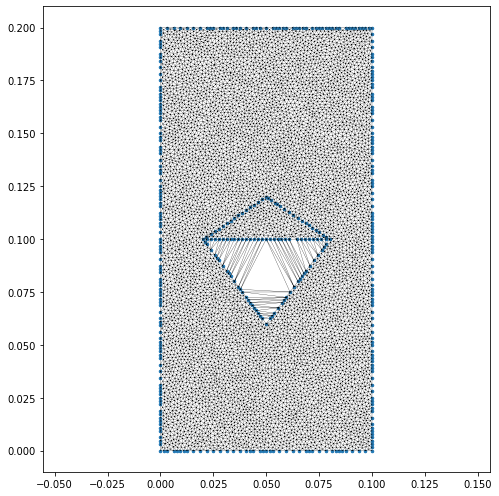

In [3]:
# Create the mesh for the inflatable sheet
m, iwv, iwbv = sheet_meshing.forward_design_mesh(
    V, E, fusedPts, holePts, np.prod(utils.bbox_dims(V)[0:2]) / 1e4
)

# Visualize the 2D mesh and highlight fused vertices
visualization.plot_2d_mesh(m, pointList=np.where(iwv)[0], width=7, height=7)

In [4]:
# Create the InflatableSheet object
isheet = inflation.InflatableSheet(m, iwv)

# Optionally set material properties if available
isheet.thickness = 0.00015         # 0.15 mm (TPU nylon 70D)
isheet.youngModulus = 2.5e8        # 250 MPa

In [5]:
# Define target points in 3D and find nearest mesh vertices for tracking
target_points = np.array([
    [0.00, 0.00, 0.0],
    [0.00, 0.10, 0.0],
    [0.00, 0.20, 0.0]# Export the deformed mesh as an OBJ file for further use (e.g., visualization in external tools)
])

# Get rest positions and find nearest actual vertices
V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])######### v in isheet.restWallVertexPositions()

tree = KDTree(V_rest)
tracked_indices = [tree.query(p)[1] for p in target_points]

# Store rest positions for displacement calculation
rest_positions = {idx: V_rest[idx] for idx in tracked_indices}

print("Tracked indices:", tracked_indices)
print("Tracked coordinates:", [V_rest[i] for i in tracked_indices])

Tracked indices: [389, 199, 145]
Tracked coordinates: [array([0., 0., 0.]), array([0. , 0.1, 0. ]), array([0. , 0.2, 0. ])]


# Get rest positions from wall vertices only (works with isheet)
V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])

# Get Y-coordinates of wall vertices
VY = V_rest[:, 1]  # Y component

# Define desired Y-values
target_y = [0.0, 0.1, 0.2]

# Find index of closest Y for each target
tracked_indices = [np.argmin(np.abs(VY - y)) for y in target_y]

# Store rest positions
rest_positions = {idx: V_rest[idx] for idx in tracked_indices}

# Print actual tracked coordinates
print("Tracked indices:", tracked_indices)
print("Tracked coordinates:", [V_rest[i] for i in tracked_indices])


In [6]:
# Set up the on-screen viewer for interactive visualization
viewer = TriMeshViewer(isheet, width=768, height=640)
#viewer.setCameraParams(([0, 0, 5], [0, 1, 0], [0, 0, 0]))
viewer.showWireframe(True)
viewer.show()

Renderer(camera=PerspectiveCamera(aspect=1.2, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [7]:
# Set up dictionary to store trajectory over time
trajectory = {idx: [] for idx in tracked_indices}
framerate = 5  # Save every 5 iterations

def cb(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        viewer.update()  # Update on-screen viewer

# Set up optimizer options
opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.useIdentityMetric = True
opts.beta = 1e-4
opts.gradTol = 1e-10
opts.niter = 500

# Set up simulation parameters
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
isheet.pressure = 20e3  # Adjust as needed

benchmark.reset()
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)
benchmark.report()

InflatableSheet setVars	0.00419211	1
Newton iterations	96.6254	1
    InflatableSheet energy	0.000451803	1
    Newton iterate	96.6243	160
        Backtracking	0.843607	159
            InflatableSheet energy	0.153993	246
            InflatableSheet setVars	0.676018	246
        Compute descent direction	92.8094	159
            newton_step	92.8088	159
                Newton solve	88.1592	200
                    CHOLMOD Numeric Factorize	85.9738	199
                    Solve	1.75166	160
                        CHOLMOD Backsub	1.40787	159
                        CHOLMOD Numeric Factorize	0.0635729	1
                        CHOLMOD Symbolic Factorize	0.259367	1
                hessEval	4.54226	159
                largestMagnitudeEigenvalue	0.0388079	1
        Preamble	2.9053	160
            Callback	2.54133	160
            InflatableSheet energy	0.0951185	160
            InflatableSheet gradient	0.231537	160
Full time	96.6532


In [8]:
# Re-initialize the sheet if you want a fresh start for the video
isheet = inflation.InflatableSheet(m, iwv)
isheet.thickness = 0.00015
isheet.youngModulus = 2.5e8
isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)
isheet.pressure = 20e3

opts.niter = 500  # or as needed

# Set up offscreen viewer for video recording
oview = OffscreenTriMeshViewer(isheet, width=768, height=640, wireframe=True)
oview.setCameraParams(([-2.50, 5, 4.33], [0, 0, 1], [0, 0, 0]))# -30 F


# Tracking for video run
trajectory = {idx: [] for idx in tracked_indices}
def cb_video(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        oview.update()

benchmark.reset()
oview.recordStart('inflation_A10-2.mp4')
cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb_video)
benchmark.report()
oview.recordStop()

InflatableSheet setVars	0.00833988	1
Newton iterations	89.1577	1
    InflatableSheet energy	0.000360012	1
    Newton iterate	89.1568	148
        Backtracking	0.868607	147
            InflatableSheet energy	0.179574	247
            InflatableSheet setVars	0.674322	247
        Compute descent direction	85.5636	147
            newton_step	85.563	147
                Newton solve	81.4895	190
                    CHOLMOD Numeric Factorize	79.3934	189
                    Solve	1.636	148
                        CHOLMOD Backsub	1.43743	147
                        CHOLMOD Numeric Factorize	0.017586	1
                        CHOLMOD Symbolic Factorize	0.160005	1
                hessEval	3.97794	147
                largestMagnitudeEigenvalue	0.030745	1
        Preamble	2.67531	148
            Callback	2.3559	148
            InflatableSheet energy	0.0841317	148
            InflatableSheet gradient	0.203098	148
Full time	89.2144


In [9]:
# Export the deformed mesh as an OBJ file for further use (e.g., visualization in external tools)
def write_obj(path, V, F):
    with open(path, "w") as f:
        for v in V:
            f.write("v {:.6f} {:.6f} {:.6f}\n".format(*v))
        for face in F:
            f.write("f {} {} {}\n".format(*(face + 1)))  # OBJ is 1-indexed

# Get the deformed geometry from the sheet
V_raw, F_raw, *_ = isheet.visualizationGeometry()
V = np.array([v.flatten() for v in V_raw], dtype=np.float64)
F = np.array([f for f in F_raw], dtype=np.int32)
write_obj("infl_mesh_10-2.obj", V, F)

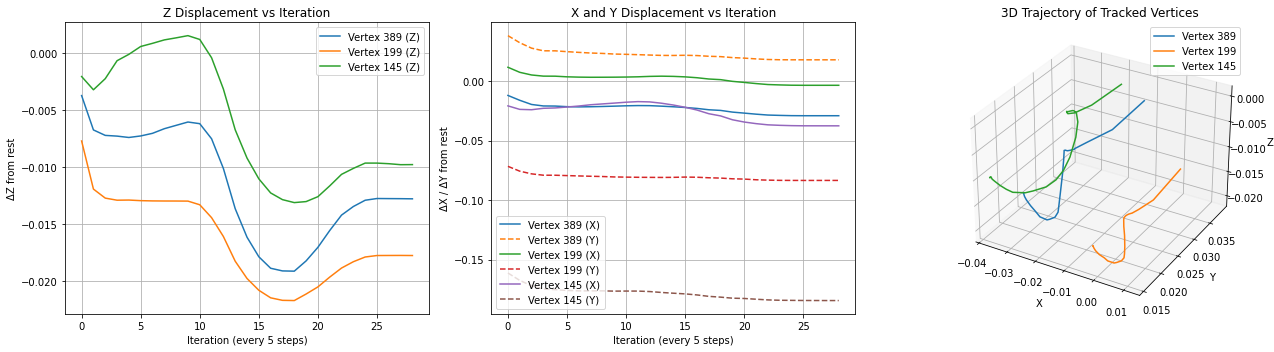

In [10]:
# Plot Z displacement, X/Y displacement, and 3D trajectory for tracked vertices
fig = plt.figure(figsize=(18, 5))

# Z Displacement
ax1 = fig.add_subplot(1, 3, 1)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        z_disp = traj[:, 2] - rest_positions[idx][2]
        ax1.plot(range(len(traj)), z_disp, label=f"Vertex {idx} (Z)")
ax1.set_title("Z Displacement vs Iteration")
ax1.set_xlabel(f"Iteration (every {framerate} steps)")
ax1.set_ylabel("ΔZ from rest")
ax1.grid(True)
ax1.legend()

# X and Y Displacement
ax2 = fig.add_subplot(1, 3, 2)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        x_disp = traj[:, 0] - rest_positions[idx][0]
        y_disp = traj[:, 1] - rest_positions[idx][1]
        ax2.plot(range(len(traj)), x_disp, label=f"Vertex {idx} (X)")
        ax2.plot(range(len(traj)), y_disp, linestyle='--', label=f"Vertex {idx} (Y)")
ax2.set_title("X and Y Displacement vs Iteration")
ax2.set_xlabel(f"Iteration (every {framerate} steps)")
ax2.set_ylabel("ΔX / ΔY from rest")
ax2.grid(True)
ax2.legend()

# 3D Trajectory
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        ax3.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")
ax3.set_title("3D Trajectory of Tracked Vertices")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Z")
ax3.legend()

plt.tight_layout()
plt.show()

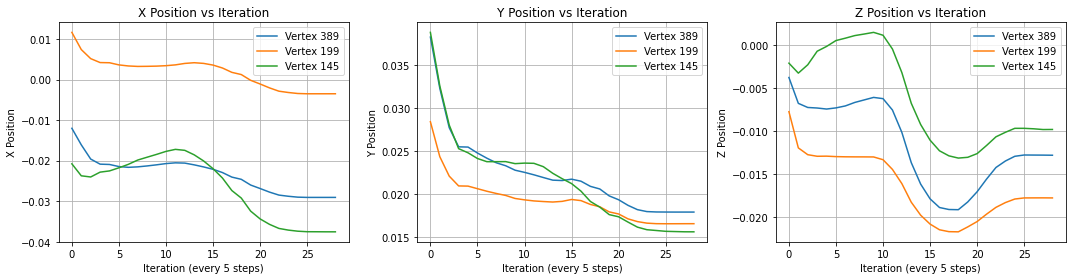

In [11]:
# Plot absolute X, Y, Z positions vs iteration for each tracked vertex
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    iterations = range(len(traj))
    axs[0].plot(iterations, traj[:, 0], label=f"Vertex {idx}")
    axs[1].plot(iterations, traj[:, 1], label=f"Vertex {idx}")
    axs[2].plot(iterations, traj[:, 2], label=f"Vertex {idx}")

# X
axs[0].set_title("X Position vs Iteration")
axs[0].set_xlabel(f"Iteration (every {framerate} steps)")
axs[0].set_ylabel("X Position")
axs[0].grid(True)
axs[0].legend()

# Y
axs[1].set_title("Y Position vs Iteration")
axs[1].set_xlabel(f"Iteration (every {framerate} steps)")
axs[1].set_ylabel("Y Position")
axs[1].grid(True)
axs[1].legend()

# Z
axs[2].set_title("Z Position vs Iteration")
axs[2].set_xlabel(f"Iteration (every {framerate} steps)")
axs[2].set_ylabel("Z Position")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [12]:
print("Target points:")
for p in target_points:
    print(p)
print("\nTracked indices and their rest positions:")
for idx in tracked_indices:
    print(f"Index: {idx}, Rest position: {rest_positions[idx]}")
    print(f"Distance to target: {np.linalg.norm(rest_positions[idx] - target_points[tracked_indices.index(idx)])}")

Target points:
[0. 0. 0.]
[0.  0.1 0. ]
[0.  0.2 0. ]

Tracked indices and their rest positions:
Index: 389, Rest position: [0. 0. 0.]
Distance to target: 0.0
Index: 199, Rest position: [0.  0.1 0. ]
Distance to target: 0.0
Index: 145, Rest position: [0.  0.2 0. ]
Distance to target: 0.0


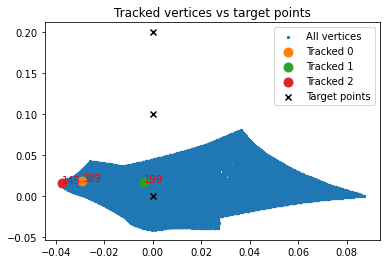

In [13]:
import matplotlib.pyplot as plt

V2d = np.array([v[:2] for v in V])  # If V is Nx3
plt.scatter(V2d[:,0], V2d[:,1], s=5, label='All vertices')
for i, idx in enumerate(tracked_indices):
    plt.scatter(V2d[idx,0], V2d[idx,1], s=80, label=f'Tracked {i}')
    plt.text(V2d[idx,0], V2d[idx,1], str(idx), color='red')
plt.scatter([p[0] for p in target_points], [p[1] for p in target_points], marker='x', color='k', label='Target points')
plt.legend()
plt.title("Tracked vertices vs target points")
plt.show()